In [1]:
!pip install cartopy
!pip install hmtk
!pip install basemap
!pip install openquake-engine
!pip install HMTKBaseMap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 36.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement hmtk (from versions: none)
ERROR: No matching distribution found for hmtk
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement HMTKBaseMap (from versions: none)
ERROR: No matching distribution found for HMTKBaseMap


In [2]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from openquake.hmtk.sources.area_source import mtkAreaSource
from openquake.hmtk.sources.point_source import mtkPointSource
from openquake.hmtk.plotting.beachball import Beach
from openquake.hmtk.plotting.plotting_utils import DISSIMILAR_COLOURLIST
from openquake.hmtk.sources.simple_fault_source import mtkSimpleFaultSource
from openquake.hmtk.sources.complex_fault_source import mtkComplexFaultSource


DEFAULT_SYMBOLOGY = [(-np.inf, 1., 'k.'), # M < 1
                     (1., 2., 'g*'), # 1 < M < 2
                     (2., 3.,'cx'), # 2 < M < 3
                     (3., 4.,'yd'), # 3 < M < 4
                     (4., 5.,'m^'), # 4 < M < 5
                     (5., 6.,'go'), # 5 < M < 6
                     (6., 7.,'yh'), # 6 < M < 7
                     (7., 8.,'bs'), # 7 < M < 8
                     (8., 9.,'k^'), # 8 < M < 9
                     (9., np.inf,'ro')] # 9 < M < 10

LEGEND_OFFSET=(1.3, 1.0)
PORTRAIT_ASPECT = (6, 8)
LANDSCAPE_ASPECT = (8, 6)
NCOLS = len(DISSIMILAR_COLOURLIST)

def _fault_polygon_from_mesh(source):
    """

    """
    # Mesh
    upper_edge = np.column_stack([source.geometry.mesh.lons[1],
                                  source.geometry.mesh.lats[1],
                                  source.geometry.mesh.depths[1]])
    lower_edge = np.column_stack([source.geometry.mesh.lons[-1],
                                  source.geometry.mesh.lats[-1],
                                  source.geometry.mesh.depths[-1]])
    return np.vstack([upper_edge, np.flipud(lower_edge), upper_edge[0, :]])

class HMTKBaseMap(object):
    '''
    Class to plot the spatial distribution of events based in the Catalogue
    imported from openquake.hmtk.
    '''
    def __init__(self, config, title, dpi=300):
        """
        :param dict config:
            Configuration parameters of the algorithm, containing the
            following information -
                'min_lat' Minimum value of latitude (in degrees, float)
                'max_lat' Minimum value of longitude (in degrees, float)
                (min_lat, min_lon) Defines the inferior corner of the map

                'min_lon' Maximum value of latitude (in degrees, float)
                'max_lon' Maximum value of longitude (in degrees, float)
                (min_lon, max_lon) Defines the upper corner of the map
        :param str title:
            Title string
        """
        self.config = config
        self.title = title
        self.dpi = dpi
        self.fig = None
        self.m = None
        self._build_basemap()

    def _build_basemap(self):
        '''
        Creates the map according to the input configuration
        '''
        if self.config['min_lon'] >= self.config['max_lon']:
            raise ValueError('Upper limit of long is smaller than lower limit')

        if self.config['min_lon'] >= self.config['max_lon']:
            raise ValueError('Upper limit of long is smaller than lower limit')
        # Corners of the map
        lowcrnrlat = self.config['min_lat']
        lowcrnrlon = self.config['min_lon']
        uppcrnrlat = self.config['max_lat']
        uppcrnrlon = self.config['max_lon']
        if not 'resolution' in self.config.keys():
            self.config['resolution'] = 'l'

        lat0 = lowcrnrlat + ((uppcrnrlat - lowcrnrlat) / 2)
        lon0 = lowcrnrlon + ((uppcrnrlon - lowcrnrlon) / 2)
        if (uppcrnrlat - lowcrnrlat) >= (uppcrnrlon - lowcrnrlon):
            fig_aspect = PORTRAIT_ASPECT
        else:
            fig_aspect = LANDSCAPE_ASPECT
        self.fig = plt.figure(num=None,
                              figsize=fig_aspect,
                              dpi=self.dpi,
                              facecolor='w',
                              edgecolor='k')
        if self.title:
            plt.title(self.title, fontsize=16)
        parallels = np.arange(-90., 90., 2.)
        meridians = np.arange(0., 360., 2.)

        # Build Map
        self.m = Basemap(
            llcrnrlon=lowcrnrlon, llcrnrlat=lowcrnrlat,
            urcrnrlon=uppcrnrlon, urcrnrlat=uppcrnrlat,
            projection='stere', resolution=self.config['resolution'],
            area_thresh=1000.0, lat_0=lat0, lon_0=lon0)
        self.m.drawcountries()
        self.m.drawmapboundary()
        self.m.drawcoastlines()
        self.m.drawstates()
        self.m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=12)
        self.m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=12)
        self.m.fillcontinents(color='wheat')

def savemap(self, filename, filetype='png', papertype="a4"):
        """
        Save the figure
        """
        self.fig.savefig(filename,
                         dpi=self.dpi,
                         format=filetype,
                         papertype=papertype)


def add_catalogue(self, catalogue, overlay=False):
        '''
        :param catalogue:
            Earthquake catalogue as instance of
            :class:`openquake.hmtk.seismicity.catalogue.Catalogue`

        :param dict config:
            Configuration parameters of the algorithm, containing the
            following information:
            'min_lat' Minimum value of latitude (in degrees, float)
            'max_lat' Minimum value of longitude (in degrees, float)
            (min_lat, min_lon) Defines the inferior corner of the map
            'min_lon' Maximum value of latitude (in degrees, float)
            'max_lon' Maximum value of longitude (in degrees, float)
            (min_lon, max_lon) Defines the upper corner of the map

        :returns:
            Figure with the spatial distribution of the events.
        '''
        # Magnitudes bins and minimum marrker size
        # min_mag = np.min(catalogue.data['magnitude'])
        # max_mag = np.max(catalogue.data['magnitude'])
        con_min = np.where(np.array([symb[0] for symb in DEFAULT_SYMBOLOGY]) <
                           np.min(catalogue.data['magnitude']))[0]
        con_max = np.where(np.array([symb[1] for symb in DEFAULT_SYMBOLOGY]) >
                           np.max(catalogue.data['magnitude']))[0]
        if len(con_min) == 1:
            min_loc = con_min[0]
        else:
            min_loc = con_min[-1]
        if len(con_max) == 1:
            max_loc = con_max[0]
        else:
            max_loc = con_max[1]
        #min_loc = np.where(np.array([symb[0] for symb in DEFAULT_SYMBOLOGY]) <
        #                   np.min(catalogue.data['magnitude']))[0][-1]
        #max_loc = np.where(np.array([symb[1] for symb in DEFAULT_SYMBOLOGY]) >
        #                   np.max(catalogue.data['magnitude']))[0][1]
        symbology = DEFAULT_SYMBOLOGY[min_loc:max_loc]
        legend_list = []
        leg_handles = []
        for sym in symbology:
            # Create legend string
            if np.isinf(sym[0]):
                leg_str = 'M < %5.2f' % sym[1]
            elif np.isinf(sym[1]):
                leg_str = 'M >= %5.2f' % sym[0]
            else:
                leg_str = '%5.2f <= M < %5.2f' %(sym[0], sym[1])
            idx = np.logical_and(catalogue.data['magnitude'] >= sym[0],
                                 catalogue.data['magnitude'] < sym[1])
            mag_size = 1.2 * np.min([sym[0] + 0.5, sym[1] - 0.5])
            x, y = self.m(catalogue.data['longitude'][idx],
                          catalogue.data['latitude'][idx])
            self.m.plot(x, y, sym[2], markersize=mag_size, label=leg_str)

        plt.legend(bbox_to_anchor=LEGEND_OFFSET)
        if self.title:
            plt.title(self.title, fontsize=16)
        if not overlay:
            plt.show()


def _plot_area_source(self, source, border='k-', border_width=1.0):
        """
        Plots the area source
        :param source:
            Area source as instance of :class: mtkAreaSource
        :param str border:
            Line properties of border (see matplotlib documentation for detail)
        :param float border_width:
            Line width of border (see matplotlib documentation for detail)
        """
        lons = np.hstack([source.geometry.lons, source.geometry.lons[0]])
        lats = np.hstack([source.geometry.lats, source.geometry.lats[0]])
        x, y = self.m(lons, lats)
        self.m.plot(x, y, border, linewidth=border_width)

def _plot_point_source(self, source, point_marker='ks', point_size=2.0):
        """
        Plots the area source
        :param source:
            Area source as instance of :class: mtkPointSource
        :param str point_marker:
            Marker style for point (see matplotlib documentation for detail)
        :param float marker size for point:
            Line width of border (see matplotlib documentation for detail)
        """
        x, y = self.m(source.geometry.longitude, source.geometry.latitude)
        self.m.plot(x, y, point_marker, markersize=point_size)

def _plot_simple_fault(self, source, border='k-', border_width=1.0):
        """
        Plots the simple fault source as a composite of the fault trace
        and the surface projection of the fault.
        :param source:
            Fault source as instance of :class: mtkSimpleFaultSource
        :param str border:
            Line properties of border (see matplotlib documentation for detail)
        :param float border_width:
            Line width of border (see matplotlib documentation for detail)
        """
        # Get the trace
        trace_lons = np.array([pnt.longitude
                               for pnt in source.fault_trace.points])
        trace_lats = np.array([pnt.latitude
                               for pnt in source.fault_trace.points])
        surface_projection = _fault_polygon_from_mesh(source)
        # Plot surface projection first
        x, y = self.m(surface_projection[:, 0], surface_projection[:, 1])
        self.m.plot(x, y, border, linewidth=border_width)
        # Plot fault trace
        x, y = self.m(trace_lons, trace_lats)
        self.m.plot(x, y, border, linewidth=1.3 * border_width)

def _plot_complex_fault(self, source, border='k-', border_width=1.0,
            min_depth=0., max_depth=None, alpha=1.0):
        """
        Plots the simple fault source as a composite of the fault trace
        and the surface projection of the fault.
        :param source:
            Fault source as instance of :class: mtkSimpleFaultSource
        :param str border:
            Line properties of border (see matplotlib documentation for detail)
        :param float border_width:
            Line width of border (see matplotlib documentation for detail)
        """
        if not max_depth:
            max_depth = 70.
        # Get outline
        top_edge = np.column_stack([source.geometry.mesh.lons[0],
                                    source.geometry.mesh.lats[0]])

        bottom_edge = np.column_stack([source.geometry.mesh.lons[-1][::-1],
                                       source.geometry.mesh.lats[-1][::-1]])
        outline = np.vstack([top_edge, bottom_edge, top_edge[0,:]])
        lons = source.geometry.mesh.lons.flatten()
        lats = source.geometry.mesh.lats.flatten()
        depths = source.geometry.mesh.depths.flatten()
        norm = Normalize(vmin=min_depth, vmax=max_depth)
        x1, y1 = self.m(lons, lats)
        self.m.scatter(x1, y1,
                       marker=".",
                       s=20,
                       c=depths,
                       norm=norm,
                       cmap="jet_r",
                       alpha=alpha,
                       linewidths=0.0,
                       zorder=4)
        # Plot border
        x2, y2 = self.m(outline[:, 0], outline[:, 1])
        self.m.plot(x2, y2, border, linewidth=border_width)

def add_source_model(
            self, model, area_border='k-', border_width=1.0,
            point_marker='ks', point_size=2.0, overlay=False, min_depth=0.,
            max_depth=None, alpha=1.0):
        """
        Adds a source model to the map

        :param model:
            Source model of mixed typologies as instance of :class:
            openquake.hmtk.sources.source_model.mtkSourceModel
        """
        for source in model.sources:
            if isinstance(source, mtkAreaSource):
                self._plot_area_source(source, area_border, border_width)
            elif isinstance(source, mtkPointSource):
                self._plot_point_source(source, point_marker, point_size)
            elif isinstance(source, mtkComplexFaultSource):
                self._plot_complex_fault(source, area_border, border_width,
                                         min_depth, max_depth, alpha)
            elif isinstance(source, mtkSimpleFaultSource):
                self._plot_simple_fault(source, area_border, border_width)
            else:
                pass
        if not overlay:
            plt.show()


def add_colour_scaled_points(self, longitude, latitude, data, shape='s',
                                 alpha=1.0, size=20, norm=None, overlay=False):
        """
        Overlays a set of points on a map with a fixed size but colour scaled
        according to the data

        :param np.ndarray longitude:
            Longitude
        :param np.ndarray latitude:
            Latitude
        :param np.ndarray data:
            Data for plotting
        :param str shape:
            Marker style
        :param float alpha:
            Sets the transparency of the marker (0 for transparent, 1 opaque)
        :param int size:
            Marker size
        :param norm:
            Normalisation as instance of :class: matplotlib.colors.Normalize
        """
        if not norm:
            norm = Normalize(vmin=np.min(data), vmax=np.max(data))
        x, y, = self.m(longitude, latitude)
        self.m.scatter(x, y,
                       marker=shape,
                       s=size,
                       c=data,
                       norm=norm,
                       alpha=alpha,
                       linewidths=0.0,
                       zorder=4)
        self.m.colorbar()
        if not overlay:
            plt.show()


def add_size_scaled_points(
            self, longitude, latitude, data, shape='o',
            logplot=False, alpha=1.0, colour='b', smin=2.0, sscale=2.0,
            overlay=False):
        """
        Plots a set of points with size scaled according to the data

        :param bool logplot:
            Choose to scale according to the logarithm (base 10) of the data
        :param float smin:
            Minimum scale size
        :param float sscale:
            Scaling factor
        """
        if logplot:
            data = np.log10(data.copy())

        x, y, = self.m(longitude, latitude)
        self.m.scatter(x, y,
                       marker=shape,
                       s=(smin + data ** sscale),
                       c=colour,
                       alpha=alpha,
                       zorder=2)
        if not overlay:
            plt.show()

def _select_color_mag(self, mag):
        if (mag > 8.0):
            color = 'k'
            #color.append('k')
        elif (mag < 8.0) and (mag >= 7.0):
            color = 'b'
            #color.append('b')
        elif (mag < 7.0) and (mag >= 6.0):
            color = 'y'
            #color.append('y')
        elif (mag < 6.0) and (mag >= 5.0):
            color = 'g'
            #color.append('g')
        elif (mag < 5.0):
            color = 'm'
            #color.append('m')
        return color

def add_focal_mechanism(self, catalogue, magnitude=None, overlay=True):
        """
        Plots a the the focal mechanism based on the beachball representation.
        The focal_menchanism flag must contain: strike, dip, rake.
        """
        longitude = catalogue.data['longitude']
        latitude = catalogue.data['latitude']
        strike = catalogue.data['strike1']
        dip = catalogue.data['dip1']
        rake = catalogue.data['rake1']

        if not magnitude or (magnitude < 0):
            magnitude = catalogue.data['magnitude']
            for i, mag in enumerate(magnitude):
                color = self._select_color_mag(mag)
                focal_mechanism = [strike[i], dip[i], rake[i]]
                x, y = self.m(longitude[i], latitude[i])
                self.m.plot(x, y)
                size = mag * 10000
                beach = Beach(focal_mechanism, linewidth=1, xy=(x, y),
                              width=size, zorder=size, facecolor=color)
                plt.gca().add_collection(beach)
                if not overlay:
                    plt.show()
        else:
            for i in xrange(0, catalogue.get_number_tensors()):
                x, y = self.m(longitude[i], latitude[i])
                self.m.plot(x, y)
                focal_mechanism = [strike[i], dip[i], rake[i]]
                size = magnitude * 10000.
                beach = Beach(focal_mechanism, linewidth=1, xy=(x, y),
                              width=size, zorder=size, facecolor='r')
                plt.gca().add_collection(beach)
                if not overlay:
                    plt.show()

def add_catalogue_cluster(self, catalogue, vcl, flagvector,
            cluster_id=None, overlay=True):
        """
        Creates a plot of a catalogue showing where particular clusters exist
        """
        # Create simple magnitude scaled point basemap
        self.add_size_scaled_points(catalogue.data['longitude'],
                                    catalogue.data['latitude'],
                                    catalogue.data['magnitude'],
                                    shape="o",
                                    alpha=0.8,
                                    colour=(0.5, 0.5, 0.5),
                                    smin=1.0,
                                    sscale=1.5,
                                    overlay=True)
        # If cluster ID is not specified just show mainshocks
        if cluster_id is None:
            idx = flagvector == 0
            self.add_size_scaled_points(catalogue.data['longitude'][idx],
                                        catalogue.data['latitude'][idx],
                                        catalogue.data['magnitude'][idx],
                                        shape="o",
                                        colour="r",
                                        smin=1.0,
                                        sscale=1.5,
                                        overlay=overlay)
            return
        if not isinstance(cluster_id, collections.Iterable):
            cluster_id = [cluster_id]
        for iloc, clid in enumerate(cluster_id):
            if iloc == (len(cluster_id) - 1):
                # On last iteration set overlay to function overlay
                temp_overlay = overlay
            else:
                temp_overlay = True
            idx = vcl == clid
            self.add_size_scaled_points(
                catalogue.data["longitude"][idx],
                catalogue.data["latitude"][idx],
                catalogue.data["magnitude"][idx],
                shape="o",
                colour=DISSIMILAR_COLOURLIST[(iloc + 1) % NCOLS],
                smin=1.0,
                sscale=1.5,
                overlay=temp_overlay)

In [3]:
import os
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from openquake.hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
#from openquake.hmtk.plotting.mapping import HMTKBaseMap
from openquake.hmtk.plotting.seismicity.completeness import plot_stepp_1972
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from openquake.hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from openquake.hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_recurrence_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence,
                                                                get_completeness_adjusted_table,
                                                               _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hmtk.seismicity.declusterer.dec_afteran import Afteran
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1
from openquake.hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow,
                                                                         GruenthalWindow,
                                                                         UhrhammerWindow)

# Completeness tools
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Recurrence methods
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from openquake.hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from openquake.hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from openquake.hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment

# Seismicity tools: Smoothed seismicity
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian

In [6]:
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser

# URL of the dataset
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
file_path = "usgs_california_1968_2018.csv"


# Parsing the catalogue from CSV to HMTK
#parser = CsvCatalogueParser(dataset_url)

# Read and process the catalogue content
#catalogue = parser.read_file(start_year=1968, end_year=2018)

# How many events in the catalogue?
#print("The catalogue contains %g events" % catalogue.get_number_events())

# What is the geographical extent of the catalogue?
#bbox = catalogue.get_bounding_box()
#print("Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox)


In [7]:
import pandas as pd
import numpy as np

# Fungsi untuk menghitung waktu (t) berdasarkan magnitudo (M)
def calculate_time(M):
    if M >= 4.5:
        t = 10**(0.032 * M + 2.7389)
    else:
        t = 10**(0.5409 * M - 0.547)
    return t

# Fungsi untuk menghitung jarak (d) berdasarkan magnitudo (M)
def calculate_distance(M):
    d = 10**(0.1238 * M + 0.983)
    return d

# Membaca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset_url)

# Menentukan waktu (t) dan jarak (d) untuk setiap gempa dalam dataset
df['time'] = df['mag'].apply(calculate_time)
df['distance'] = df['mag'].apply(calculate_distance)

# Menampilkan hasil
df[['time', 'distance']]


,time,distance
0,13.151400,23.136838
1,7.143828,20.120650
2,13.316221,23.202886
3,10.251608,21.854657
4,7.143828,20.120650
...,...,...
247803,4.978173,18.524223
247804,3.512513,17.103146
247805,5.103734,18.630135
247806,9.164547,21.301098


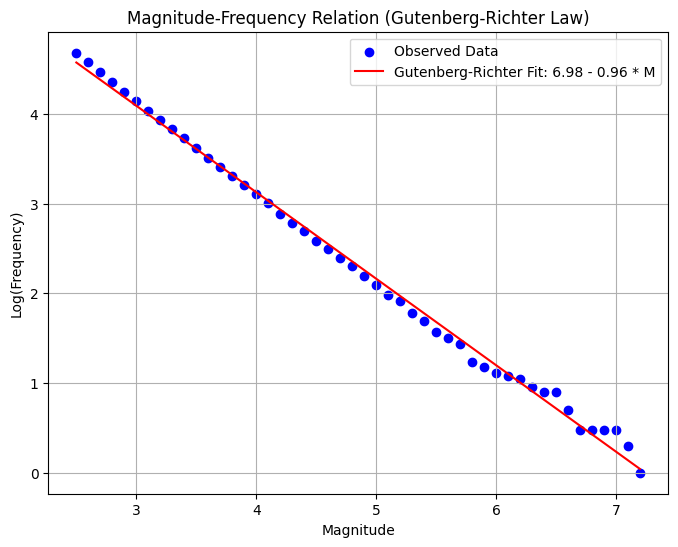

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Fungsi untuk menghitung waktu (t) berdasarkan magnitudo (M)
def calculate_time(M):
    if M >= 6.5:
        t = 10**(0.032 * M + 2.7389)
    else:
        t = 10**(0.5409 * M - 0.547)
    return t

# Fungsi untuk menghitung jarak (d) berdasarkan magnitudo (M)
def calculate_distance(M):
    d = 10**(0.1238 * M + 0.983)
    return d

# Membaca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset_url)

# Menghitung waktu (t) dan jarak (d) untuk setiap gempa dalam dataset
df['time'] = df['mag'].apply(calculate_time)
df['distance'] = df['mag'].apply(calculate_distance)

# Menampilkan hasil
#print("Data dengan perhitungan waktu dan jarak:")
#df.head()

# Hapus nilai NaN atau infinitas dari kolom 'mag'
data = df.dropna(subset=['mag'])

# Hitung frekuensi kejadian gempa per rentang magnitudo
magnitudes = np.arange(2.5, 8.6, 0.1)  # Rentang magnitudo
frequency = []

for mag in magnitudes:
    count = len(data[data['mag'] >= mag])
    frequency.append(count)

# Hapus nol dari frekuensi untuk menghindari log(0)
frequency = np.array(frequency)
frequency = frequency[frequency != 0].flatten()

# Fungsi untuk regresi linear pada skala log-log (Gutenberg-Richter)
def gutenberg_richter(m, a, b):
    return a - b * m

# Perkirakan parameter a dan b untuk garis regresi
popt, pcov = curve_fit(gutenberg_richter, magnitudes[:len(frequency)], np.log10(frequency))

# Plot MFR (Magnitude-Frequency Relation) pada skala log-log dengan garis regresi
plt.figure(figsize=(8, 6))
plt.scatter(magnitudes[:len(frequency)], np.log10(frequency), color='blue', label='Observed Data')
plt.plot(magnitudes[:len(frequency)], gutenberg_richter(magnitudes[:len(frequency)], *popt), color='red', label=f'Gutenberg-Richter Fit: {popt[0]:.2f} - {popt[1]:.2f} * M')
plt.xlabel('Magnitude')
plt.ylabel('Log(Frequency)')
plt.title('Magnitude-Frequency Relation (Gutenberg-Richter Law)')
plt.legend()
plt.grid(True)
plt.show()

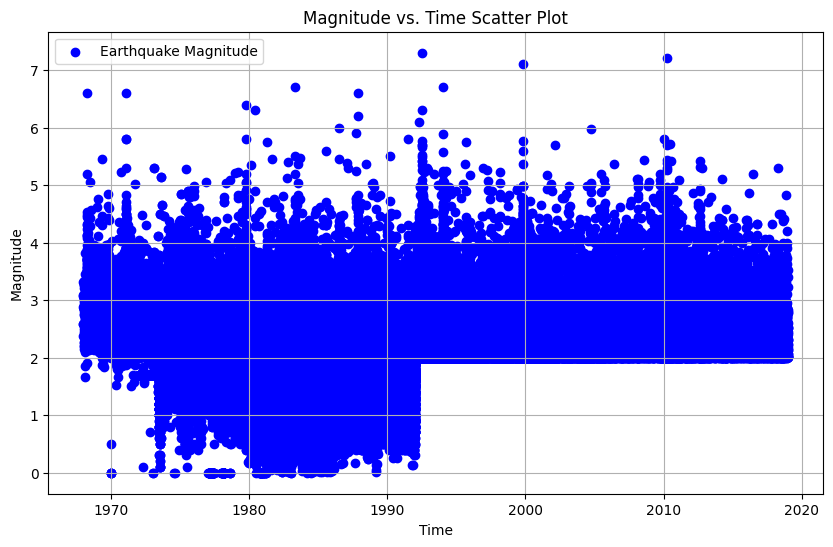

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_magnitude_time_scatter(catalogue, plot_error=True):
    catalogue['time'] = pd.to_datetime(catalogue['time'])  # Ubah kolom 'time' menjadi tipe datetime
    plt.figure(figsize=(10, 6))
    plt.scatter(catalogue['time'], catalogue['mag'], color='blue', label='Earthquake Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.title('Magnitude vs. Time Scatter Plot')
    if plot_error and 'mag_err' in catalogue.columns:
        plt.errorbar(catalogue['time'], catalogue['mag'], yerr=catalogue['mag_err'], fmt='o', color='red', alpha=0.5, label='Magnitude Error')
    plt.legend()
    plt.grid(True)
    plt.show()

# Baca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
earthquake_data = pd.read_csv(dataset_url)

# Contoh penggunaan fungsi plot_magnitude_time_scatter
plot_magnitude_time_scatter(earthquake_data, plot_error=True)


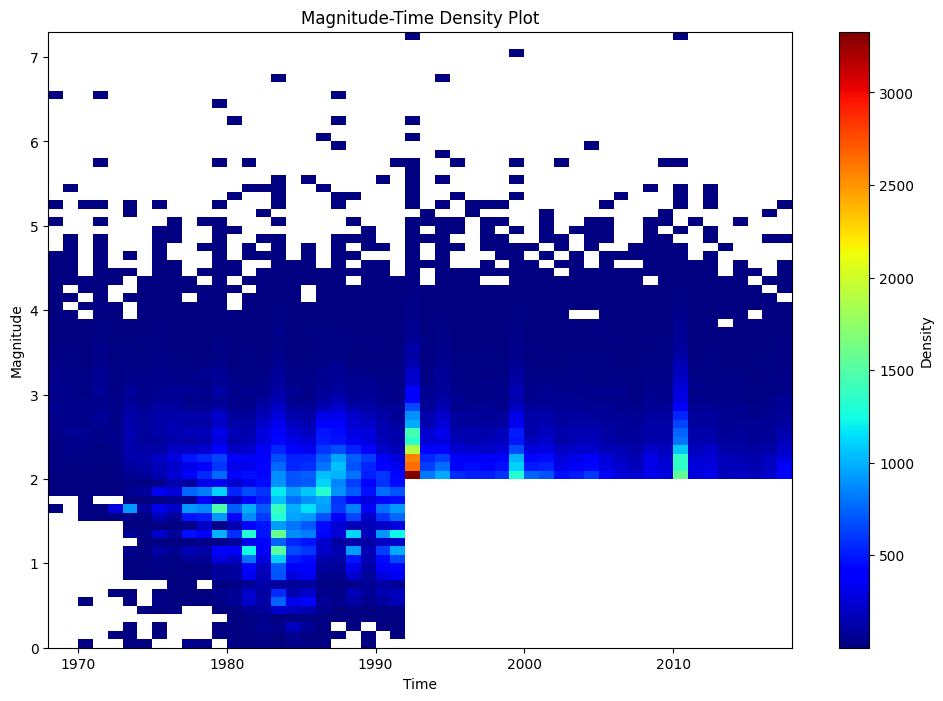

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Membaca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset_url)

# Mengonversi kolom 'time' menjadi objek waktu
df['time'] = pd.to_datetime(df['time'])

# Plot magnitude vs. time density
def plot_magnitude_time_density(catalogue, magnitude_bin_width, time_bin_width):
    # Membuat rentang waktu dan magnitudo
    time_min = catalogue['time'].min().year
    time_max = catalogue['time'].max().year
    magnitude_min = catalogue['mag'].min()
    magnitude_max = catalogue['mag'].max()

    # Menentukan bins untuk waktu dan magnitudo
    time_bins = np.arange(time_min, time_max + time_bin_width, time_bin_width)
    magnitude_bins = np.arange(magnitude_min, magnitude_max + magnitude_bin_width, magnitude_bin_width)

    # Menghitung histogram 2D
    H, xedges, yedges = np.histogram2d(catalogue['time'].dt.year, catalogue['mag'], bins=[time_bins, magnitude_bins])

    # Atur nilai putih untuk area tanpa gempa
    H[H == 0] = np.nan

    # Plot density plot
    plt.figure(figsize=(12, 8))
    plt.pcolormesh(xedges, yedges, H.T, cmap='jet', vmin=np.nanmin(H), vmax=np.nanmax(H))
    plt.colorbar(label='Density')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.title('Magnitude-Time Density Plot')
    plt.show()

# Mengatur lebar bins untuk waktu dan magnitudo
magnitude_bin_width = 0.1
time_bin_width = 1

# Memanggil fungsi plot
plot_magnitude_time_density(df, magnitude_bin_width, time_bin_width)


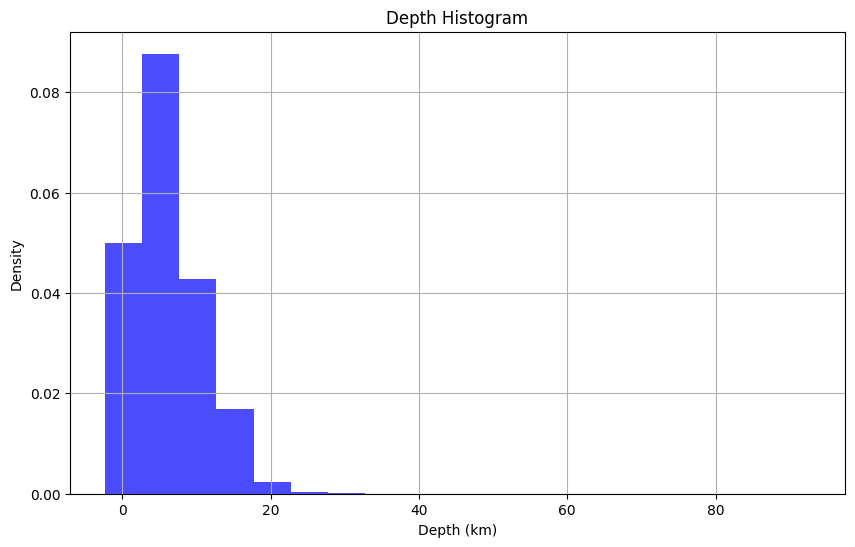

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menghitung waktu (t) berdasarkan magnitudo (M)
def calculate_time(M):
    if M >= 6.5:
        t = 10**(0.032 * M + 2.7389)
    else:
        t = 10**(0.5409 * M - 0.547)
    return t

# Membaca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset_url)

# Menghitung waktu (t) untuk setiap gempa dalam dataset
df['time'] = df['mag'].apply(calculate_time)

# Plot depth histogram
def plot_depth_histogram(catalogue, depth_bin_width, normalisation=True):
    # Filter out NaN values in the depth column
    catalogue = catalogue.dropna(subset=['depth'])

    # Define depth bins
    depth_min = catalogue['depth'].min()
    depth_max = catalogue['depth'].max()
    depth_bins = np.arange(depth_min, depth_max + depth_bin_width, depth_bin_width)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(catalogue['depth'], bins=depth_bins, density=normalisation, color='blue', alpha=0.7)
    plt.xlabel('Depth (km)')
    plt.ylabel('Density' if normalisation else 'Frequency')
    plt.title('Depth Histogram')
    plt.grid(True)
    plt.show()

# Example usage:
depth_bin_width = 5.0
plot_depth_histogram(df, depth_bin_width, normalisation=True)


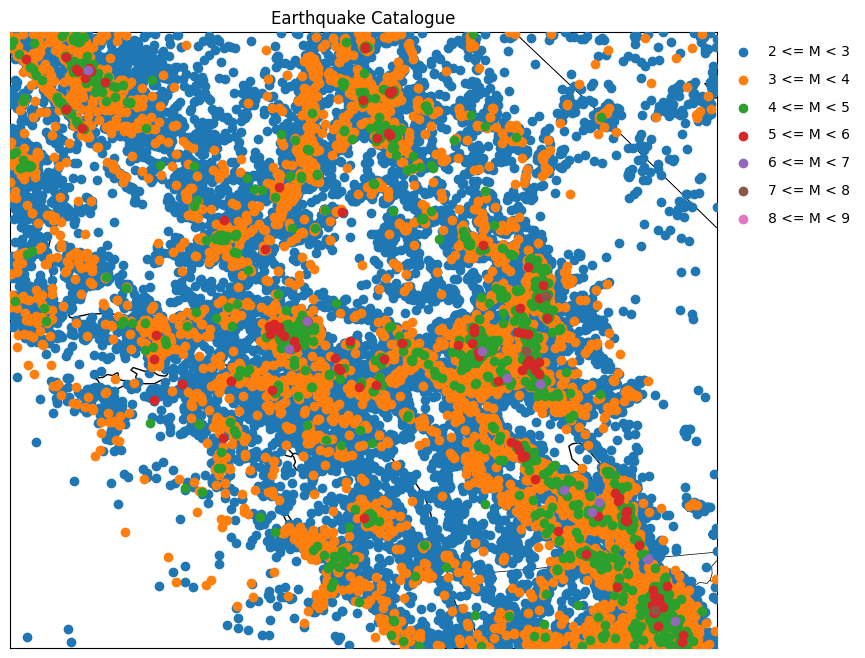

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Membaca dataset dari URL
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1968_2018.csv"
df = pd.read_csv(dataset_url)

# Mendapatkan batasan peta (bounding box) dari dataset
llon, ulon = df['longitude'].min(), df['longitude'].max()
llat, ulat = df['latitude'].min(), df['latitude'].max()

# Membuat peta
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlon=llon, llcrnrlat=llat, urcrnrlon=ulon, urcrnrlat=ulat, resolution='i')
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Rentang magnitudo untuk legenda
magnitude_ranges = [(2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]

# Plot titik-titik gempa bumi pada peta dan tambahkan legenda
for mag_range in magnitude_ranges:
    subset = df[(df['mag'] >= mag_range[0]) & (df['mag'] < mag_range[1])]
    x, y = m(subset['longitude'].values, subset['latitude'].values)
    m.scatter(x, y, marker='o', label=f'{mag_range[0]} <= M < {mag_range[1]}', zorder=5)

# Tambahkan legenda di kanan atas di luar grafik
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Earthquake Catalogue')
plt.show()
